# Arvores de Decisão e Florestas Randômicas (Decision Trees and Random Forests)

Aqui vamos dar uma olhada em motivar dois poderoso algoritmo - um algoritmo não paramétrico chamado florestas randomicas e as árvores de decisão. As florestas randomicas são um exemplo de método de conjunto, o que significa que ele se baseia na agregação dos resultados de um conjunto de estimadores mais simples. O resultado um tanto surpreendente com esses métodos de conjunto é que a soma pode ser maior que as partes: ou seja, uma votação majoritária entre vários estimadores pode acabar sendo melhor do que qualquer um dos estimadores individuais que estão votando! Veremos exemplos disso nas seções a seguir. Começamos com as importações padrão além de códigos para ajudar na visualização:

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')

In [35]:
%%file helpers_05_08.py

import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from ipywidgets import interact


def visualize_tree(estimator, X, y, boundaries=True,
                   xlim=None, ylim=None, ax=None):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()
    
    # fit the estimator
    estimator.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    n_classes = len(np.unique(y))
    Z = Z.reshape(xx.shape)
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='viridis', clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
    # Plot the decision boundaries
    def plot_boundaries(i, xlim, ylim):
        if i >= 0:
            tree = estimator.tree_
        
            if tree.feature[i] == 0:
                ax.plot([tree.threshold[i], tree.threshold[i]], ylim, '-k', zorder=2)
                plot_boundaries(tree.children_left[i],
                                [xlim[0], tree.threshold[i]], ylim)
                plot_boundaries(tree.children_right[i],
                                [tree.threshold[i], xlim[1]], ylim)
        
            elif tree.feature[i] == 1:
                ax.plot(xlim, [tree.threshold[i], tree.threshold[i]], '-k', zorder=2)
                plot_boundaries(tree.children_left[i], xlim,
                                [ylim[0], tree.threshold[i]])
                plot_boundaries(tree.children_right[i], xlim,
                                [tree.threshold[i], ylim[1]])
            
    if boundaries:
        plot_boundaries(0, xlim, ylim)


def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1,3,5,7])


def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0, 100]);

Overwriting helpers_05_08.py


## Introduzindo Florestas Randomicas: Arvores de Decisão

Florestas randomicas são um exemplo de um * ensemble learning * construído em árvores de decisão.
Por esse motivo, começaremos discutindo as próprias árvores de decisão.

As árvores de decisão são maneiras extremamente intuitivas de classificar ou rotular objetos: basta você fazer uma série de perguntas projetadas para se concentrar na classificação.
Por exemplo, se você deseja construir uma árvore de decisão para classificar um animal que você encontra durante uma caminhada, você pode construir o mostrado aqui:

[0, 1, 0, 1]

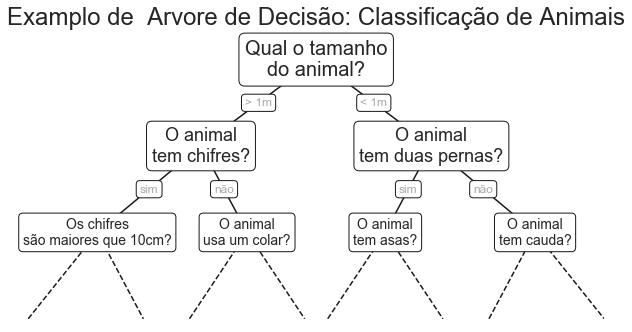

In [36]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_axes([0, 0, 0.8, 1], frameon=False, xticks=[], yticks=[])
ax.set_title('Examplo de  Arvore de Decisão: Classificação de Animais', size=24)

def text(ax, x, y, t, size=20, **kwargs):
    ax.text(x, y, t,
            ha='center', va='center', size=size,
            bbox=dict(boxstyle='round', ec='k', fc='w'), **kwargs)

text(ax, 0.5, 0.9, "Qual o tamanho\ndo animal?", 20)
text(ax, 0.3, 0.6, "O animal\ntem chifres?", 18)
text(ax, 0.7, 0.6, "O animal\ntem duas pernas?", 18)
text(ax, 0.12, 0.3, "Os chifres\nsão maiores que 10cm?", 14)
text(ax, 0.38, 0.3, "O animal\nusa um colar?", 14)
text(ax, 0.62, 0.3, "O animal\ntem asas?", 14)
text(ax, 0.88, 0.3, "O animal\ntem cauda?", 14)

text(ax, 0.4, 0.75, "> 1m", 12, alpha=0.4)
text(ax, 0.6, 0.75, "< 1m", 12, alpha=0.4)

text(ax, 0.21, 0.45, "sim", 12, alpha=0.4)
text(ax, 0.34, 0.45, "não", 12, alpha=0.4)

text(ax, 0.66, 0.45, "sim", 12, alpha=0.4)
text(ax, 0.79, 0.45, "não", 12, alpha=0.4)

ax.plot([0.3, 0.5, 0.7], [0.6, 0.9, 0.6], '-k')
ax.plot([0.12, 0.3, 0.38], [0.3, 0.6, 0.3], '-k')
ax.plot([0.62, 0.7, 0.88], [0.3, 0.6, 0.3], '-k')
ax.plot([0.0, 0.12, 0.20], [0.0, 0.3, 0.0], '--k')
ax.plot([0.28, 0.38, 0.48], [0.0, 0.3, 0.0], '--k')
ax.plot([0.52, 0.62, 0.72], [0.0, 0.3, 0.0], '--k')
ax.plot([0.8, 0.88, 1.0], [0.0, 0.3, 0.0], '--k')
ax.axis([0, 1, 0, 1])

#fig.savefig('figures/05.08-decision-tree.png')

A divisão binária torna isso extremamente eficiente: em uma árvore bem construída, cada pergunta reduz o número de opções pela metade, estreitando muito rapidamente as opções, mesmo em um grande número de classes. 

O truque, é claro, vem ao decidir quais perguntas fazer em cada etapa. 

Nas implementações de aprendizado de máquina de árvores de decisão, as perguntas geralmente assumem a forma de divisões alinhadas aos eixos nos dados:

**ou seja, cada nó na árvore divide os dados em dois grupos usando um valor de corte em um dos recursos. Vamos agora ver um exemplo disso.**

### Criando uma árvore de decisão

Considere os seguintes dados bidimensionais, que possuem um dos quatro rótulos de classe:

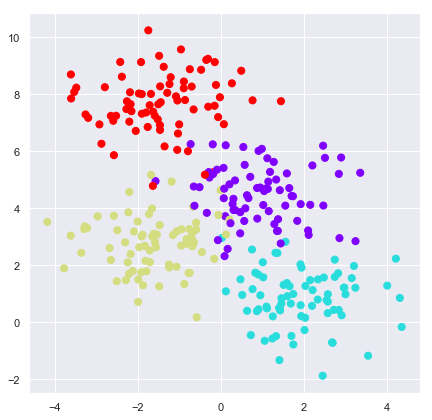

In [37]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
fig = plt.figure(figsize=(7, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

Uma árvore de decisão simples criada com base nesses dados dividirá iterativamente os dados ao longo de um ou outro eixo de acordo com algum critério quantitativo e, em cada nível, atribuirá o rótulo da nova região de acordo com o voto da maioria dos pontos.

Esta figura apresenta uma visualização dos quatro primeiros níveis de um classificador de árvore de decisão para esses dados:

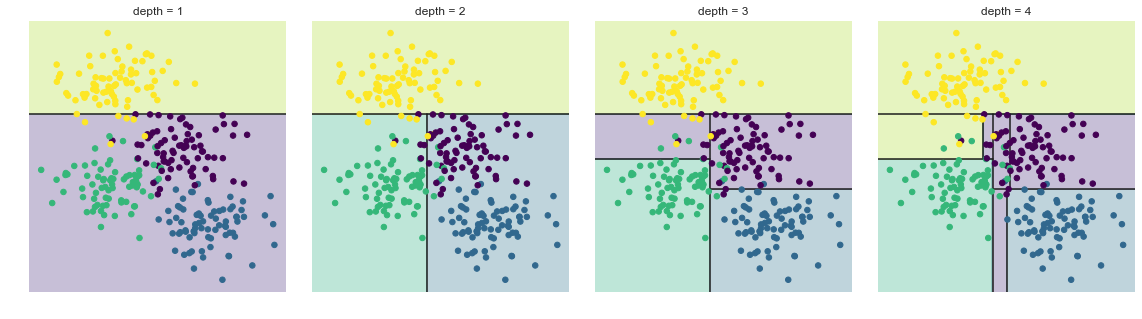

In [38]:
from helpers_05_08 import visualize_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs

        
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
fig.subplots_adjust(left=0.02, right=0.98, wspace=0.1)

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

for axi, depth in zip(ax, range(1, 5)):
    model = DecisionTreeClassifier(max_depth=depth)
    visualize_tree(model, X, y, ax=axi)
    axi.set_title('depth = {0}'.format(depth))

Observe que, após a primeira divisão, todos os pontos da ramificação superior permanecem inalterados; portanto, não há necessidade de subdividir ainda mais essa ramificação.

Exceto nos nós que contêm todas as cores, em cada nível * cada * região é novamente dividida ao longo de um dos dois recursos.

Esse processo de ajuste de uma árvore de decisão aos nossos dados pode ser feito no Scikit-Learn com o estimador `` DecisionTreeClassifier``:

In [39]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Vamos escrever uma função de utilidade rápida para nos ajudar a visualizar a saída do classificador:

In [40]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

Agora podemos examinar como é a classificação da árvore de decisão:

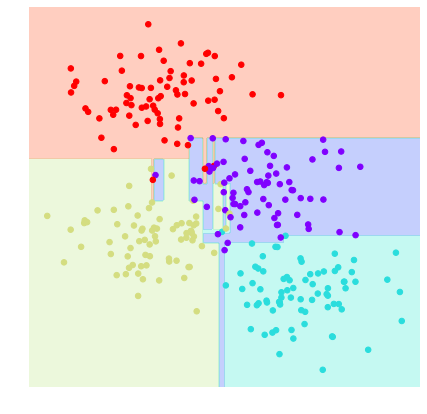

In [41]:
fig = plt.figure(figsize=(7, 7))
visualize_classifier(DecisionTreeClassifier(), X, y)

If you're running this notebook live, you can use the helpers script included in [The Online Appendix](06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

In [47]:
from ipywidgets import interact
def plot_tree_interactive(X, y):
    def interactive_tree(depth=5):
        clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
        fig = plt.figure(figsize=(7, 7))
        visualize_tree(clf, X, y)

    return interact(interactive_tree, depth=[1,3,5,7])

In [48]:
# helpers_05_08 is found in the online appendix
#import helpers_05_08

plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=2, options=(1, 3, 5, 7), value=5), Output()), _dom_c…

Observe que, à medida que a profundidade aumenta, tendemos a obter regiões de classificação com formas muito estranhas; por exemplo, a uma profundidade de cinco, há uma região roxa alta e magra entre as regiões amarela e azul.

Está claro que isso é menos o resultado da verdadeira distribuição intrínseca de dados e mais o resultado das propriedades específicas de amostragem ou ruído dos dados.

Ou seja, essa árvore de decisão, mesmo com apenas cinco níveis de profundidade, está claramente superestimando nossos dados.

### Árvores de decisão e overfitting

Essa adaptação excessiva acaba sendo uma propriedade geral das árvores de decisão: é muito fácil ir fundo demais na árvore e, assim, ajustar detalhes dos dados específicos, em vez das propriedades gerais das distribuições das quais elas são extraídas.
Outra maneira de ver esse ajuste excessivo é observar modelos treinados em diferentes subconjuntos de dados - por exemplo, nesta figura, treinamos duas árvores diferentes, cada uma com metade dos dados originais:

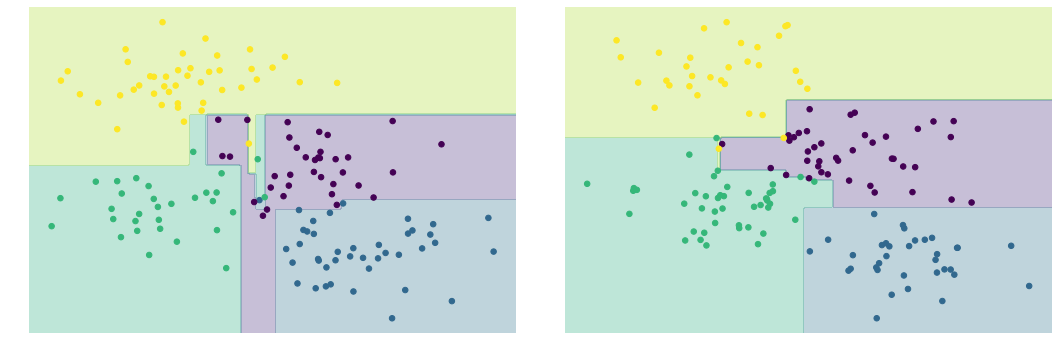

In [49]:
model = DecisionTreeClassifier()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
visualize_tree(model, X[::2], y[::2], boundaries=False, ax=ax[0])
visualize_tree(model, X[1::2], y[1::2], boundaries=False, ax=ax[1])

É claro que em alguns lugares, as duas árvores produzem resultados consistentes (por exemplo, nos quatro cantos), enquanto em outros lugares, as duas árvores dão classificações muito diferentes (por exemplo, nas regiões entre dois grupos).

A observação principal é que as inconsistências tendem a ocorrer onde a classificação é menos certa e, portanto, usando as informações de * ambas * dessas árvores, podemos obter um resultado melhor!

In [55]:
def randomized_tree_interactive(X, y):
    N = int(0.75 * X.shape[0])
    
    xlim = (X[:, 0].min(), X[:, 0].max())
    ylim = (X[:, 1].min(), X[:, 1].max())
    
    def fit_randomized_tree(random_state=0):
        clf = DecisionTreeClassifier(max_depth=15)
        i = np.arange(len(y))
        rng = np.random.RandomState(random_state)
        rng.shuffle(i)
        fig = plt.figure(figsize=(7, 7))
        visualize_tree(clf, X[i[:N]], y[i[:N]], boundaries=False,
                       xlim=xlim, ylim=ylim)
    
    interact(fit_randomized_tree, random_state=[0,100]);

In [56]:
# helpers_05_08 is found in the online appendix
#import helpers_05_08
randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

Assim como o uso de informações de duas árvores melhora nossos resultados, podemos esperar que o uso de informações de muitas árvores melhore ainda mais nossos resultados.

## Conjuntos de estimadores: florestas aleatórias

Essa noção - que vários estimadores de super ajuste podem ser combinados para reduzir o efeito desse super ajuste - é o que sustenta um método de conjunto chamado * bagging *.
O bagging utiliza um conjunto (talvez um saco de compras) de estimadores paralelos, cada um dos quais se ajusta aos dados, e calcula a média dos resultados para encontrar uma melhor classificação.
Um conjunto de árvores de decisão aleatórias é conhecido como * floresta randômica *.

Esse tipo de classificação de ensacamento pode ser feito manualmente usando o meta-estimador `` BaggingClassifier`` do Scikit-Learn, como mostrado aqui:

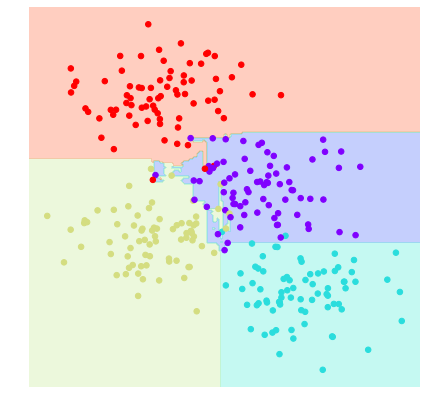

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
fig = plt.figure(figsize=(7, 7))
visualize_classifier(bag, X, y)

Neste exemplo, randomizamos os dados ajustando cada estimador com um subconjunto aleatório de 80% dos pontos de treinamento.

Na prática, as árvores de decisão são randomizadas de maneira mais eficaz ao injetar certa estocástica na maneira como as divisões são escolhidas: dessa forma, todos os dados contribuem para o ajuste a cada vez, mas os resultados do ajuste ainda têm a aleatoriedade desejada.

Por exemplo, ao determinar em qual recurso dividir, a árvore aleatória pode selecionar dentre os vários recursos principais.

Você pode ler mais detalhes técnicos sobre essas estratégias de randomização na [documentação do Scikit-Learn] (http://scikit-learn.org/stable/modules/ensemble.html#forest) e referências.

No Scikit-Learn, esse conjunto otimizado de árvores de decisão aleatórias é implementado no estimador `` RandomForestClassifier``, que cuida de toda a randomização automaticamente.
Tudo o que você precisa fazer é selecionar um número de estimadores, e ele se ajustará muito rapidamente (em paralelo, se desejado) ao conjunto de árvores:

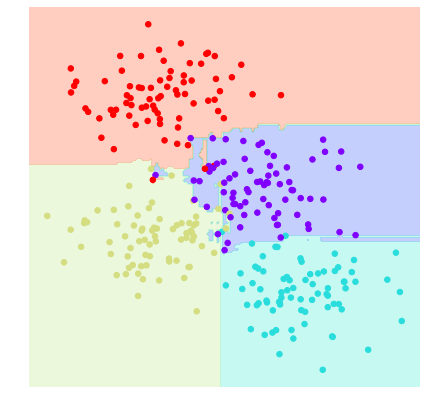

In [59]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
plt.figure(figsize=(7,7))
visualize_classifier(model, X, y);

Vemos que, calculando a média de mais de 100 modelos construídos aleatoriamente, acabamos com um modelo geral muito mais próximo da nossa intuição sobre como o espaço do parâmetro deve ser dividido.

## Random Forest Regression

a seção anterior, consideramos florestas aleatórias dentro do contexto de classificação.
Também é possível fazer com que florestas aleatórias funcionem no caso de regressão (ou seja, variáveis contínuas em vez de categóricas). O estimador a ser usado para isso é o `` RandomForestRegressor``, e a sintaxe é muito semelhante à que vimos anteriormente.

Considere os seguintes dados, extraídos da combinação de uma oscilação rápida e lenta:

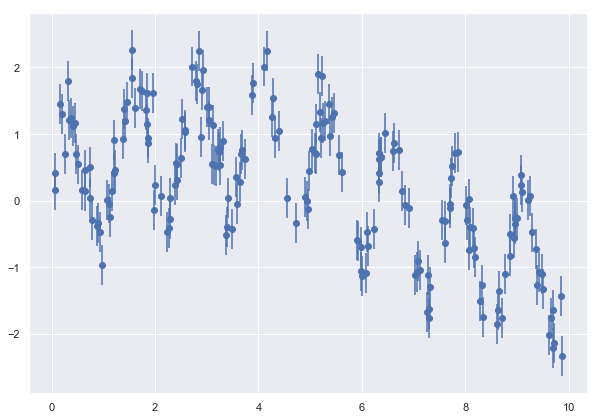

In [61]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.figure(figsize=(10,7))
plt.errorbar(x, y, 0.3, fmt='o');

Usando a regressão por florestas rand^micas, podemos encontrar a melhor curva de ajuste da seguinte maneira:

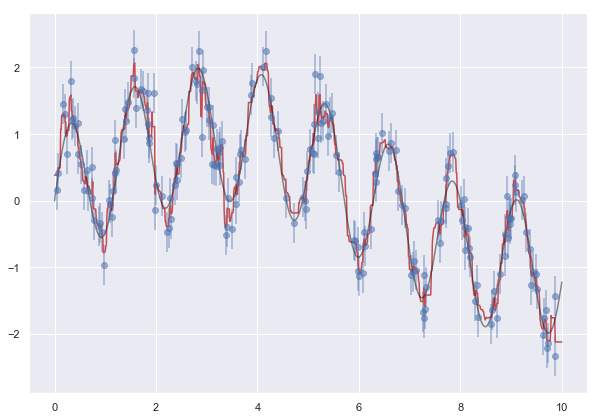

In [63]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.figure(figsize=(10,7))
plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Aqui, o modelo verdadeiro é mostrado na curva cinza suave, enquanto o modelo de floresta aleatória é mostrado pela curva vermelha irregular.

Como você pode ver, o modelo de floresta aleatória não paramétrica é flexível o suficiente para ajustar os dados de vários períodos, sem a necessidade de especificar um modelo de vários períodos!

## Example: Random Forest for Classifying Digits

Earlier we took a quick look at the hand-written digits data (see [Introducing Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb)).
Let's use that again here to see how the random forest classifier can be used in this context.

In [64]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

Para nos lembrar do que estamos vendo, visualizaremos os primeiros pontos de dados:

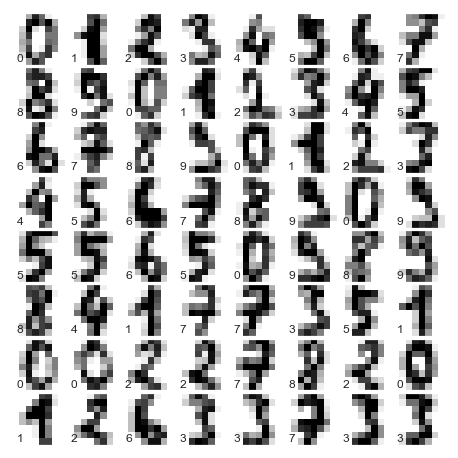

In [65]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

Podemos classificar rapidamente os dígitos usando uma floresta aleatória da seguinte maneira:

In [67]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

Podemos dar uma olhada no relatório de classificação para este classificador:

In [68]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.94      0.96        50
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.96      0.98      0.97        46

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



E, para uma boa medida, plote a matriz de confusão:

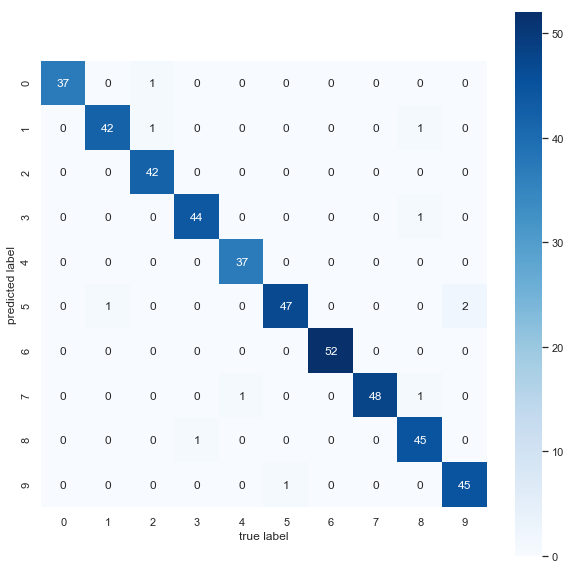

In [71]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
plt.figure(figsize=(10,10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label');